In [6]:
%reset -f
import matplotlib.pyplot as plt
import numpy as np
import random as rng
import math
import functions as f
import initialisations as ini
from timeit import default_timer as timer
start = timer()


    ###    Variables    ###
    
kb = 1.3806485279e-23 
eps = 119.8*kb          # epsilon used in potential
sg = 3.405e-10          # sigma
m = 39.94*1.67377e-27   # mass particle kg
steps = 5000            # number of half timesteps
h = .004                # timestep
D = 3                   # number of dimensions


    ###    Simulation parameters    ###
    
nobins=200                                      # no of pair correlation bins
bins=np.zeros([nobins],dtype=float)

N=3                                             # no of unit cels in each direction
n=4*N**3                                        # no of particles

T=1                                             # dimensionless temperature
rho=0.8                                         # dimensionless density

L=(n/rho)**(1/3)                                # calculate boxsize from n&rho
Lp=1/L                                          # inverse L for simulation speed

x=np.zeros([steps,D,n],dtype=float)             # define position matrix with [step,(x,y,z),#particle]
v=np.zeros([steps,D,n],dtype=float)             # define velocity matrix with [step,(x,y,z),#particle]
Pot=np.zeros([int(steps/2)],dtype=float)        # define potential energy matrix for each step
Kin=np.zeros([int(steps/2)],dtype=float)        # define kinetic energy matrix for each step
Tsim=np.zeros([int(steps/2)],dtype=float)       # define temperature matrix for each step


    ###    Simulation     ###
    
print('Initializing')
#ini.InitializeFluidPos(x,D,L,n,.1*L)            # get initial positions in a random structure
ini.InitializeFccSolidPos(x,N,D,L)              # get initial positions in a FCC structure
ini.InitializeVelocity(v,D,L,n,T)               # get initial velocities from Maxwell distribution
T0=f.KinEn(v,0) *2/(3*(n-1))                    # get initial temperature from initialisation
v=v*np.sqrt(T/T0)                               # set correct initial temperature

for i in range(steps-1):
    i2=int(i/2)                                 # Pot&Kin only updated after a whole Leapfrog step
    if i%2==0:
        x[i+1,:,:]=x[i,:,:]                     # Leapfrog 1/2 step, use old position                   
        v[i+1,:,:] = v[i,:,:]                   # use old velocity and add force contributions   
        for j in range(n):
            for k in range(n):
                if j!=k:
                    dx=f.SelectPart(x[i,:,k],x[i,:,j],D,L)              # vector from particle k to j
                    r=f.r(dx)                                           # distance from particle k to j
                    DivU=f.Ulj2(r)                                      # dU/dr*1/r
                    v[i+1,:,j] = v[i+1,:,j] + DivU * dx * h             # add force from each other particle
                    Pot[i2]=Pot[i2]+f.Pot(r)                            # Add potential from each particle
                    
                    if i+2>steps/10:                                    # start counting after 10%
                        bins[int(r*Lp*nobins)]=bins[int(r*Lp*nobins)]+1 # count the # of particles at distances [r,r+dr]
        Pot[i2]=Pot[i2]/2                       # Correct for the double counting of each particle
        Kin[i2]=f.KinEn(v,i)                    # Calculate the kinetic energy at each timestep
        Tsim[i2]=Kin[i2]*2/(3*(n-1))
    else:
        x[i+1,:,:]=x[i,:,:]+v[i,:,:]*h          # calculate new position, from old position + velocity * h                   
        v[i+1,:,:] = v[i,:,:]                   # use old velocity                                                              
        f.poscheck(x,i,D,n,L)                   # check if particles have moved outside the box, if so: move to other side
    if (i+2)/steps*100%10==0:
        print((i+2)/steps*100,'%')              # print the progress
    if (i+2)%(steps/100)==0 and i+2<steps/10:
        v[i+1,:,:] = v[i+1,:,:]*np.sqrt((n-1)*3/2*T/Kin[i2])            # Force right temperature, 9 times after the first setting

Tot=Kin+Pot
Tinrange=Tsim[int(steps/2*1/10):int(steps/2-1)] # Take the right measuring range for energies and temperature
Kinrange=Kin[int(steps/2*1/10):int(steps/2-1)]  
Totrange=Tot[int(steps/2*1/10):int(steps/2-1)]
Potrange=Pot[int(steps/2*1/10):int(steps/2-1)]
print('Total, potential,kinetic energy and it\'s STD\s')
print(np.mean(Totrange))
print(f.BootSTDTemp(Totrange))
print(np.mean(Potrange))
print(f.BootSTDTemp(Potrange))
print(np.mean(Kinrange))
print(f.BootSTDTemp(Kinrange))


    ###    Observables     ###        
    
print('Temperature and it\'s STD')
print(np.mean(Tinrange))
print(f.BootSTDTemp(Tinrange))
print('Cv')
print(f.CvCalc(Kinrange,n))
print(f.BootSTDCv(Kinrange,n))


g=np.zeros([nobins],dtype=float)                # create the pair correlation variable and calculate
for i in range(nobins):
    g[i]=2/(n*(n-1)) * bins[i] / (4*np.pi*((i+.5)/nobins)**2/nobins)/(steps*9/20)


stop=timer()
print('Simulation time in seconds')
print(stop-start)
print('simulation 100%')

Initializing
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
Total, potential,kinetic energy and it's STD\s
-418.47607293
0.0120144240116
-573.925106725
0.139799955964
155.449033795
0.144603861266
Temperature and it's STD
0.968529805577
0.000963098108877
Cv
2.26713138046
0.0349846439463
Simulation time in seconds
855.2176202908158
simulation 100%


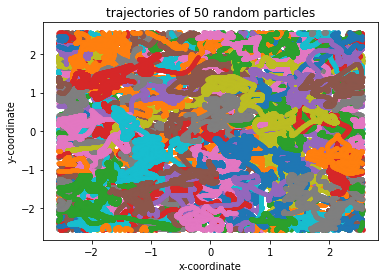

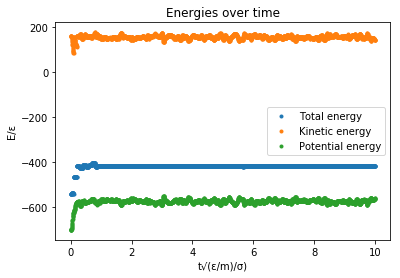

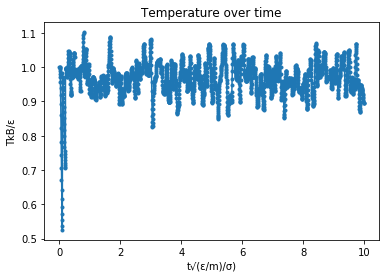

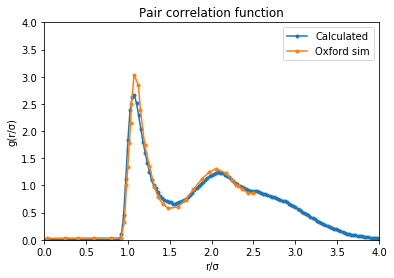

In [7]:
import matplotlib
    ###    Figures     ###  


#Plot trajectories
for i in range(n):
    plt.plot(x[:,0,i],x[:,1,i],linestyle="",marker=".")
plt.ylabel('y-coordinate')
plt.xlabel('x-coordinate')
plt.title('trajectories of 50 random particles')
plt.savefig('trajectories.png')
plt.show()

#Plot energies
plt.plot(np.arange(steps/2)*h,Tot,linestyle="",marker=".")
plt.plot(np.arange(steps/2)*h,Kin,linestyle="",marker=".")
plt.plot(np.arange(steps/2)*h,Pot,linestyle="",marker=".")
plt.legend(['Total energy', 'Kinetic energy', 'Potential energy'])
plt.xlabel('t\u221A(\u03B5/m)/\u03C3)')
plt.ylabel('E/\u03B5')
plt.title('Energies over time')
plt.savefig('energietimegas.png')
plt.show()

#Plot temperature
plt.plot(np.arange(steps/2)*h,Tsim,linestyle="-",marker=".")
plt.xlabel('t\u221A(\u03B5/m)/\u03C3)')
plt.ylabel('TkB/\u03B5')
plt.title('Temperature over time')
plt.savefig('temptimegas.png')
plt.show()


#Plot pair correlation
Meas=np.loadtxt(fname = "liguidargon.txt")
plt.plot(np.arange(nobins)*L/nobins,g/2,linestyle="-",marker=".")
plt.plot(Meas[:,0]*1e-9/sg,Meas[:,1],linestyle="-",marker=".")
plt.xlabel('r/\u03C3')
plt.ylabel('g(r/\u03C3)')
plt.title('Pair correlation function')
plt.legend(['Calculated', 'Oxford sim'])
plt.axis([0, 4, 0, 4])
plt.savefig('paircogas.png')
plt.show()

In [5]:

from IPython.display import HTML
from anim import make_3d_animation

z=np.zeros([steps,n,D],dtype=float) 
for i in range(D):
    z[:,:,i]=x[:,i,:]+.5*L

#anim = make_3d_animation(L,z, delay=90, rotate_on_play=0)
#HTML(anim.to_jshtml())
